My goal in this project would be to use varios models to analyze Diabities data collected from Kaggle and see what model perform best in predicting the incidence of diabities given some features collected for various patients. I start with a Decision Tree Classifier with the hope that it can give me an intuition on what is the sequence of decisions that leads to each outcome. For this I run the model with several values of some hyperparameters to see which one yields best accuracy for the data at hand.


# Study of Diabities data Set and Creation on ML models to predict the disease

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from google.colab import drive


# Utility Functions
def plotROC(y_test, y_predict, classifier):
  fpr, tpr, thresholds = roc_curve(y_test, y_predict)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc, estimator_name=classifier)
  display.plot()
  plt.show()

def plotConfusionMatrix(y_test, y_predict, classifier):
  print(f"Confusion Matrix for {classifier}")
  cm = confusion_matrix(y_test, y_predict)
  display = ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative'])
  display.plot()
  plt.show()

drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/diabetes.csv')

print('\nFeatures = ' + str(df.columns[:-1].to_list())) # Show features
print('\nTarget = ' + df.columns[-1])  # Show the outcome

print()
print(df.head())

print()
df.info()

Mounted at /content/gdrive

Features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Target = Outcome

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column               

## Data Visualization

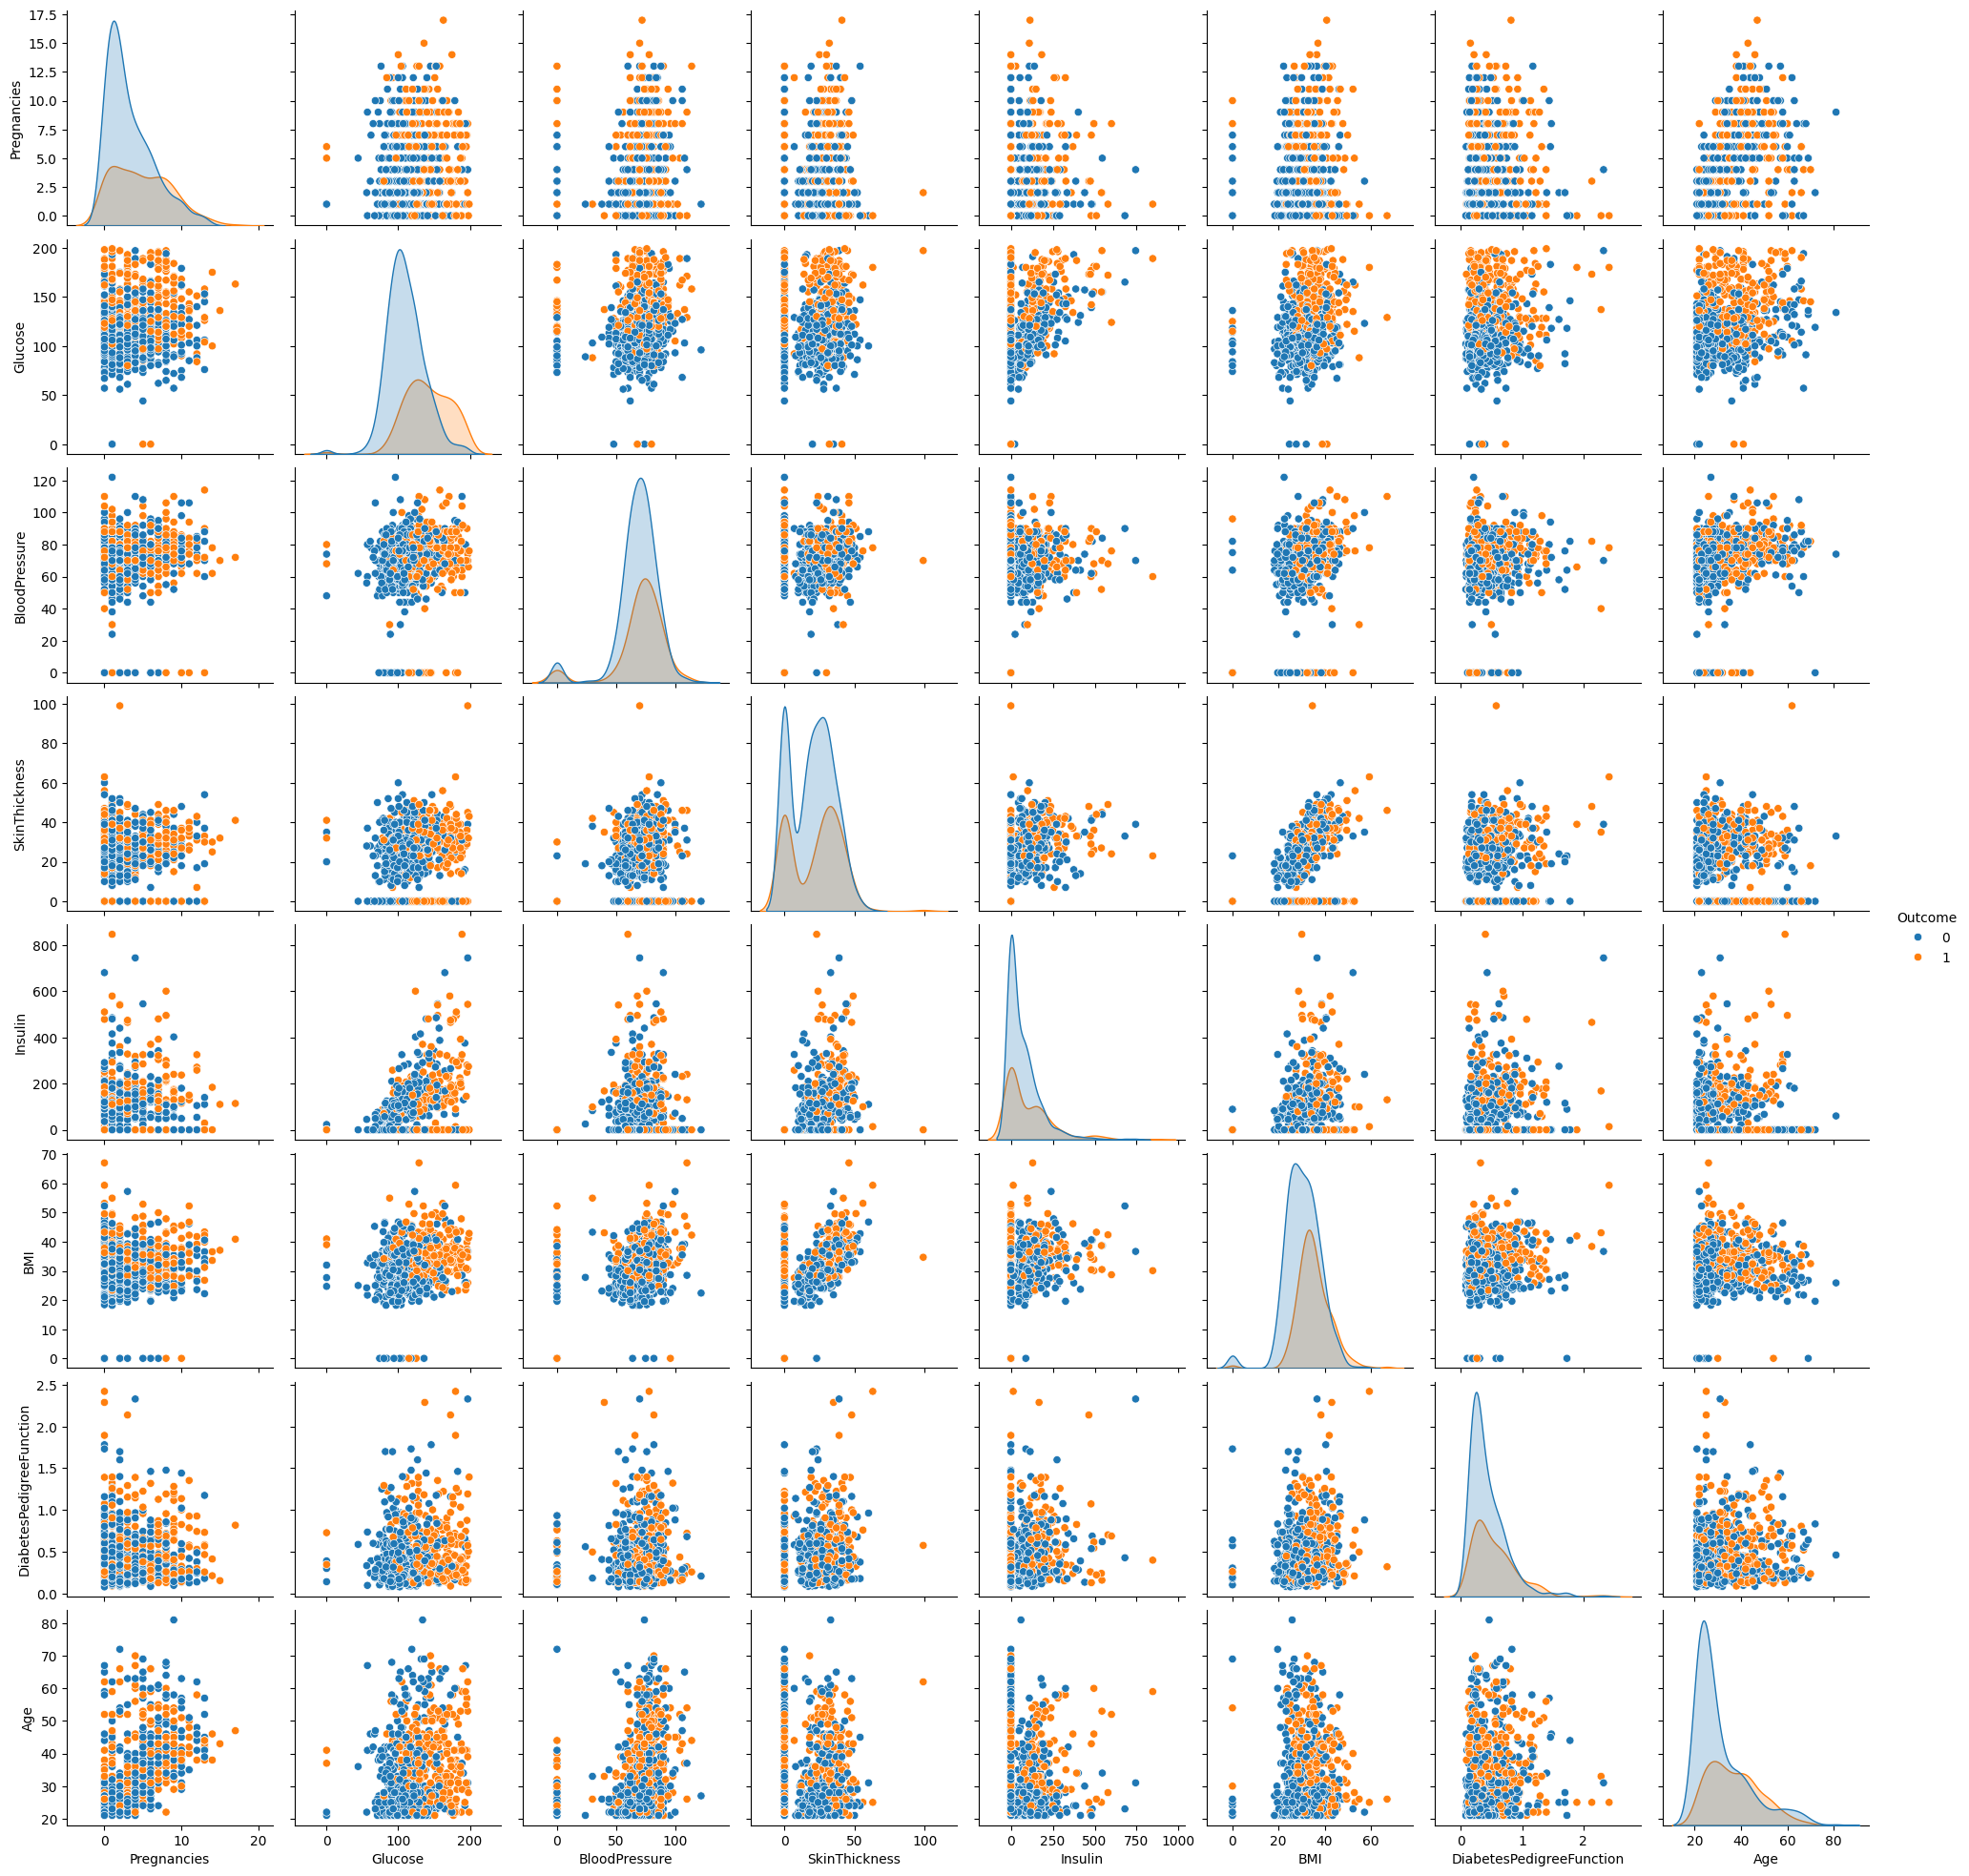

In [2]:
# Create visualization of features and their correlation with target variable
# This plot shows how separable the outcome is based on high impact features like Glucose and BMI
# Note the charts show some outliers in BMI, Bloodpressure, and Glucose that motivates
# Data clean up done later.

sns.pairplot(df, hue='Outcome')
plt.show()


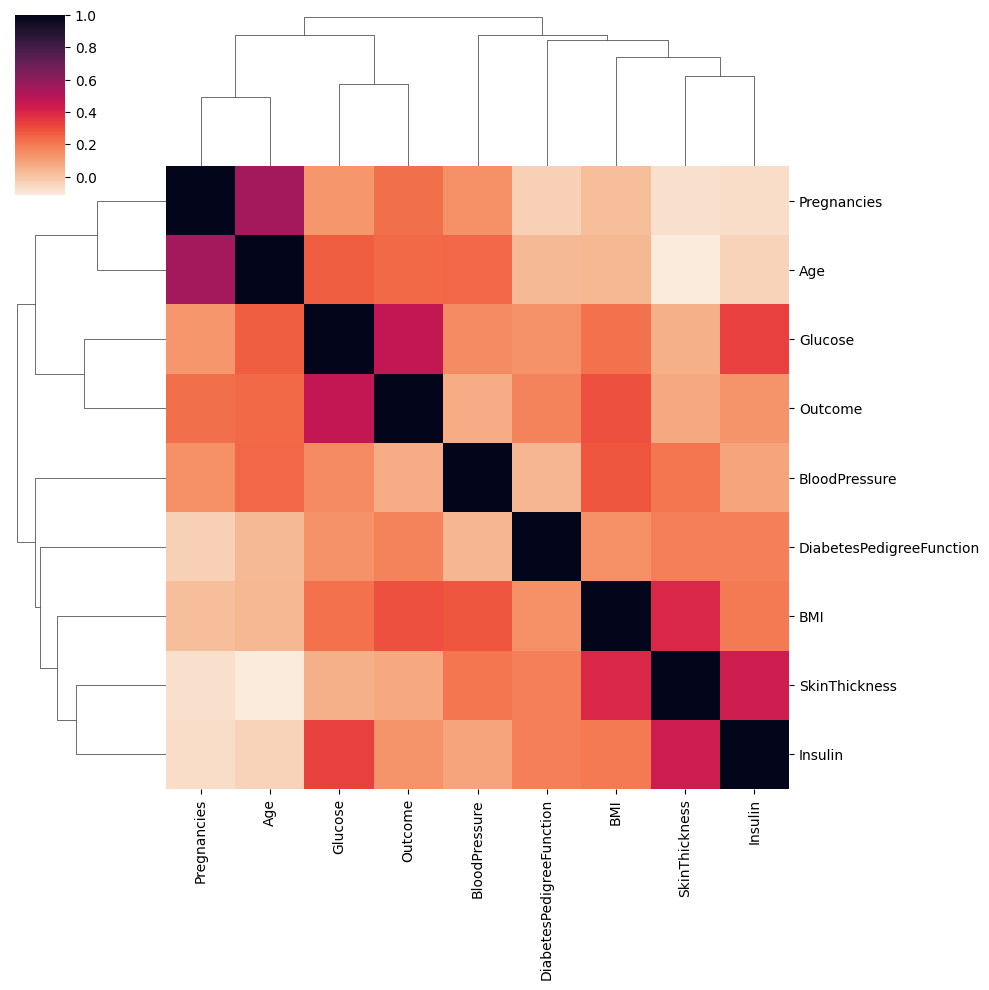

In [3]:
# Display direct correlation impact of each feature on Outcome: highest correlation on Glucose and BMI

sns.clustermap(df.corr(), cmap="rocket_r")
plt.show()

## Data Cleanup

Rows before cleaning: 768


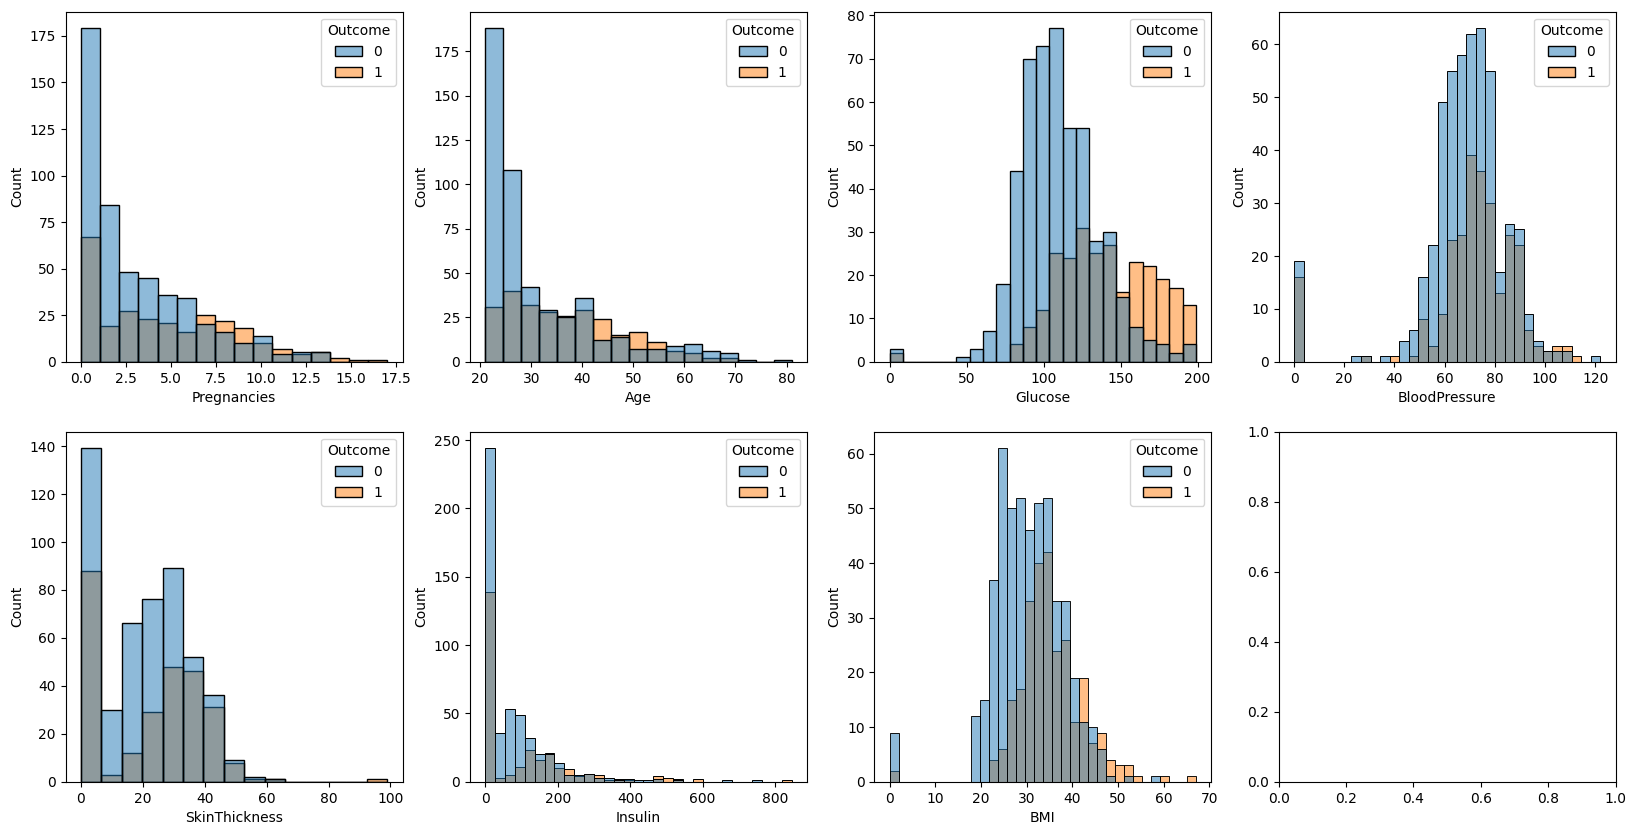

In [4]:
# Data Cleaning plot features histogram to zoom in into outliers
print(f'Rows before cleaning: {len(df)}')

fig, axs = plt.subplots(ncols=4, nrows=2)
fig.set_figheight(10)
fig.set_figwidth(20)
sns.histplot(data=df, x='Pregnancies', hue='Outcome', ax=axs[0][0])
sns.histplot(data=df, x='Age', hue='Outcome', ax=axs[0][1])
sns.histplot(data=df, x='Glucose', hue='Outcome', ax=axs[0][2])
sns.histplot(data=df, x='BloodPressure', hue='Outcome', ax=axs[0][3])
sns.histplot(data=df, x='SkinThickness', hue='Outcome', ax=axs[1][0])
sns.histplot(data=df, x='Insulin', hue='Outcome', ax=axs[1][1])
sns.histplot(data=df, x='BMI', hue='Outcome', ax=axs[1][2])
plt.show()


# Clean up Outliers and Graph again


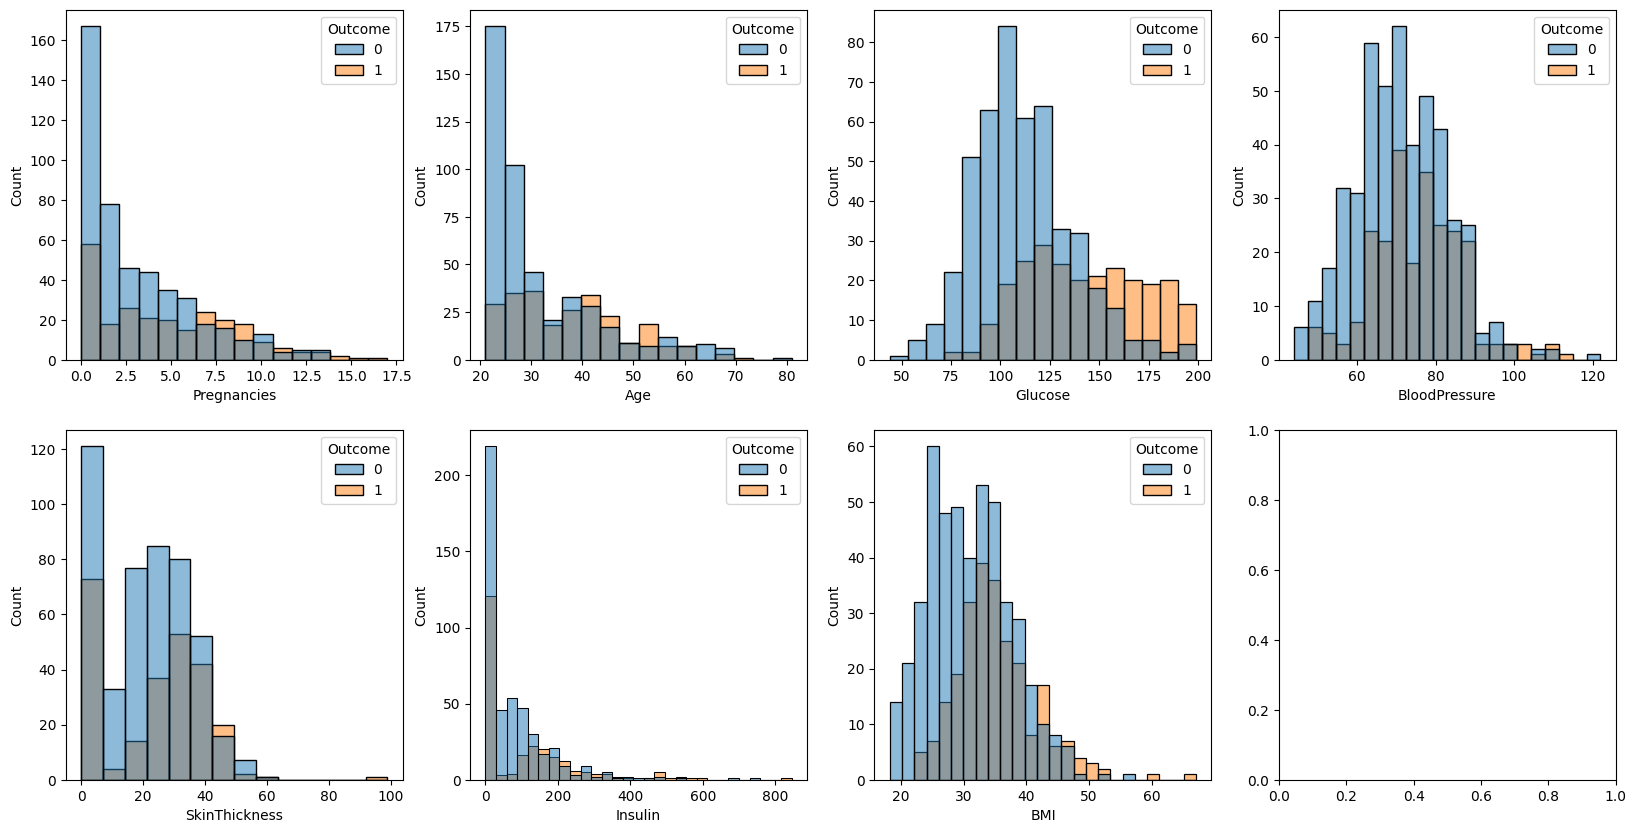

Rows after cleaning: 719


In [5]:
# Clean up entries with Glucose 0 and Blood Pressure 0
df_clean = df[(df['Glucose'] != 0) & (df['BloodPressure'] > 40) & (df['BMI'] > 5)]
fig, axs = plt.subplots(ncols=4, nrows=2)
fig.set_figheight(10)
fig.set_figwidth(20)
sns.histplot(data=df_clean, x='Pregnancies', hue='Outcome', ax=axs[0][0])
sns.histplot(data=df_clean, x='Age', hue='Outcome', ax=axs[0][1])
sns.histplot(data=df_clean, x='Glucose', hue='Outcome', ax=axs[0][2])
sns.histplot(data=df_clean, x='BloodPressure', hue='Outcome', ax=axs[0][3])
sns.histplot(data=df_clean, x='SkinThickness', hue='Outcome', ax=axs[1][0])
sns.histplot(data=df_clean, x='Insulin', hue='Outcome', ax=axs[1][1])
sns.histplot(data=df_clean, x='BMI', hue='Outcome', ax=axs[1][2])
plt.show()
print(f'Rows after cleaning: {len(df_clean)}')

## Is Data-Balanced?

In [6]:
# Determine if data is balanced

X = df_clean.iloc[:,0:-1]
y = df_clean.iloc[:,-1]

balance = 100 * y.value_counts(normalize=True)
print(f'False values % {balance[0]:.2f}')
print(f'True values  % {balance[1]:.2f}')
# Use 70/30% split as the threshold for imbalance data
if max(balance[0], balance[1]) > 70:
  print(f'\nData is imbalanced, balance: False % = {balance[0]:.2f} vs True % = {balance[1]:.2f}')
else:
  print(f'\nData is balanced, balance: False % = {balance[0]:.2f} vs True % = {balance[1]:.2f}')


False values % 65.65
True values  % 34.35

Data is balanced, balance: False % = 65.65 vs True % = 34.35


# Metrics to be Used to evaluate our models

Although in the next few lines of code I have added code to track most common metrics in classification I will mostly foucs on using Recall also know  as True Positive Rate. In disease diagnostic it is very important to know how many positives we get right and see how many psotive cases we mispredicted.

Recall = True Positive Rate = Correctly Classified Postives / All Positives
Recall = TPR = TP /(TP + FN)

The second reason for use of recall is that the data is not fully balanced and hence Accuracy may be biased due to the larger number of rows with negative rows. Hence most likely I will base my Grid Search on recall metric.

A metric of secondary importance is Precision as it factors it False Positives:

Precision = TP / (TP + FP)

So in short my priority is to correctly predict True Positives (Highest Recall) but in second place I want to have higher Precision to minimize false positives.

Ti evaluate my algorithms I have also created functions to display Confusion Matrix and ROC-AUC as they visualize the predicting power of the model.

## Train/Test Split

In [7]:
# Split the data, use startify to ensure balance between test and train sets

# We scale for all classifiers as it improves the outcome of all the non-tree based models
# and does not influence the outome of tree-based models

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0, test_size=0.20, stratify=y)

# Verify composition of train and test sets
train_balance = 100 * y_train.value_counts(normalize=True)
test_balance = 100 * y_test.value_counts(normalize=True)
print(f'Train Set Balance: False % {train_balance[0]:.2f}; True % {train_balance[1]:.2f}')
print(f'Test  Set Balance: False % {test_balance[0]:.2f}; True % {test_balance[1]:.2f}')

Train Set Balance: False % 65.57; True % 34.43
Test  Set Balance: False % 65.97; True % 34.03


## **First Level Model Exploration**
In this section I explore models performance at a first level to get some idea on how hyperparameters behave.

# A First Look At Decision Trees

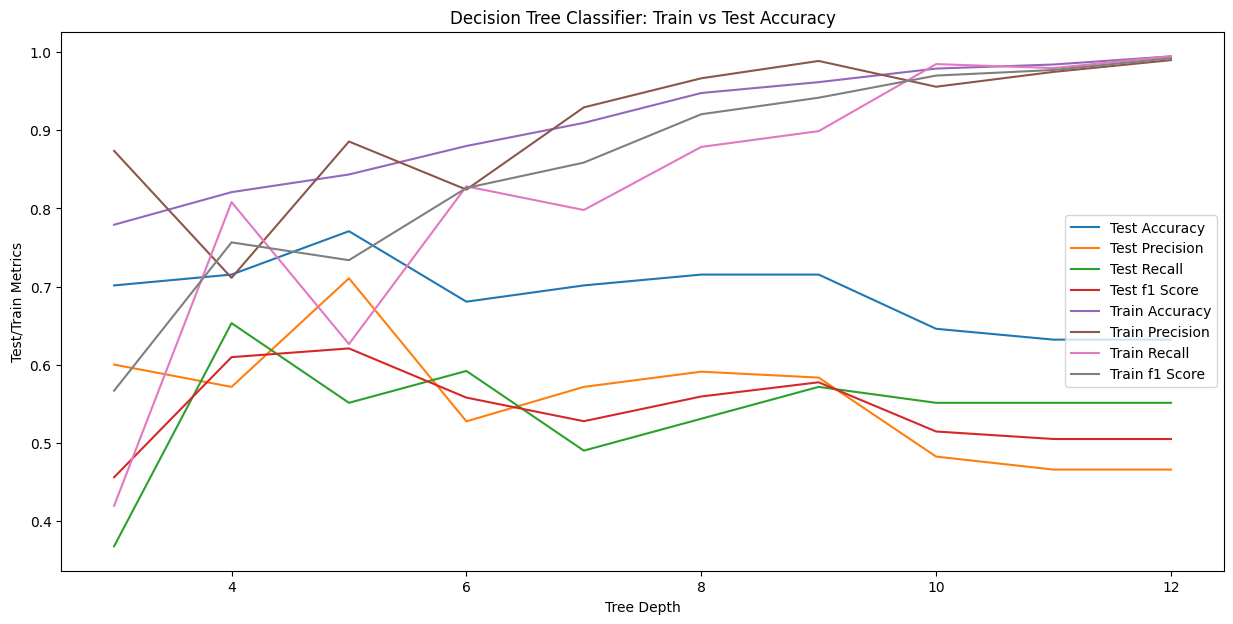

In [8]:

# Initial exploration to get a sense of accuracy and main hyper-parameter
# For the various Algorithms to be evaluated

def get_scores(y, y_predict, scores):
  scores['accuracy'].append(accuracy_score(y, y_predict))
  scores['precision'].append(precision_score(y, y_predict))
  scores['recall'].append(recall_score(y, y_predict))
  scores['f1'].append(f1_score(y, y_predict))

model_test_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}
model_train_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}

models = []
# Use these two dictionaries to store all best metrics for each model
all_best_test_metrics = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}
all_best_train_metrics = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}

best_train_metrics = {
  'accuracy' : 0,
  'precision' : 0,
  'recall' : 0,
  'f1' : 0
}

best_test_metrics = {
  'accuracy' : 0,
  'precision' : 0,
  'recall' : 0,
  'f1' : 0
}
def reset_model_scores(model_test_scores, model_train_scores):
  for key in model_test_scores.keys():
    model_test_scores[key] = []
  for key in model_train_scores.keys():
    model_train_scores[key] = []

def reset_best_metrics(best_test_metrics, best_train_metrics):
  for key in best_train_metrics.keys():
    best_train_metrics[key] = 0
  for key in best_test_metrics.keys():
    best_test_metrics[key] = 0

# Tracks best metrics observed so far based on metric_name for test
# scores. Tracks best hyper parameter
def get_best_metric(metric_name, model_test_scores, model_train_scores,
                    best_test_metrics, best_train_metrics, best_param,
                    current_param):
  if model_test_scores[metric_name][-1] > best_test_metrics[metric_name]:
    for key in best_test_metrics.keys():
      best_test_metrics[key] = model_test_scores[key][-1]
    for key in best_train_metrics.keys():
      best_train_metrics[key] = model_train_scores[key][-1]
    best_param = current_param
  return best_param

def store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics):
  for key in best_test_metrics.keys():
    all_best_test_metrics[key].append(best_test_metrics[key])
  for key in best_train_metrics.keys():
    all_best_train_metrics[key].append(best_train_metrics[key])

preferred_metric_name = 'recall'
best_depth = 0

depth_range = range(3,13)
for depth in depth_range:
  clsf = DecisionTreeClassifier(max_depth=depth, random_state=17)
  clsf.fit(X_train, y_train)
  y_test_predict = clsf.predict(X_test)
  y_train_predict =clsf.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_depth = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_depth, depth)

# Models and metrics are in order so they can be displayed later in dataframe
models.append('decision_tree')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

def plot_scores(hyper_range, model_test_scores, model_train_scores, xlabel, ylabel, title):
  plt.figure(figsize=(15,7),facecolor='white')
  plt.plot(hyper_range, model_test_scores['accuracy'], label='Test Accuracy')
  plt.plot(hyper_range, model_test_scores['precision'], label='Test Precision')
  plt.plot(hyper_range, model_test_scores['recall'], label='Test Recall')
  plt.plot(hyper_range, model_test_scores['f1'], label='Test f1 Score')
  plt.plot(hyper_range, model_train_scores['accuracy'], label='Train Accuracy')
  plt.plot(hyper_range, model_train_scores['precision'], label='Train Precision')
  plt.plot(hyper_range, model_train_scores['recall'], label='Train Recall')
  plt.plot(hyper_range, model_train_scores['f1'], label='Train f1 Score')
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

plot_scores(depth_range, model_test_scores, model_train_scores, 'Tree Depth', 'Test/Train Metrics', 'Decision Tree Classifier: Train vs Test Accuracy')


In [9]:
# Summary result of best initial Decision tree classifier


def print_best_metrics(model_name, best_test_metrics, best_train_metrics):
  print(f"\n{model_name} Classifier Test Metrics:")
  for key in best_test_metrics.keys():
    print(f"{key:10}={round(best_test_metrics[key], 3)}")
  print(f"\n{model_name} Classifier Train Metrics:")
  for key in best_train_metrics.keys():
    print(f"{key:10}={round(best_train_metrics[key], 3)}")

print(f"Decision Tree Classifier best_depth = {best_depth}")
print_best_metrics('DecisionTreeClassifier', best_test_metrics, best_train_metrics)



Decision Tree Classifier best_depth = 4

DecisionTreeClassifier Classifier Test Metrics:
accuracy  =0.715
precision =0.571
recall    =0.653
f1        =0.61

DecisionTreeClassifier Classifier Train Metrics:
accuracy  =0.821
precision =0.711
recall    =0.808
f1        =0.757


Confusion Matrix for DecisionTreeClassifier


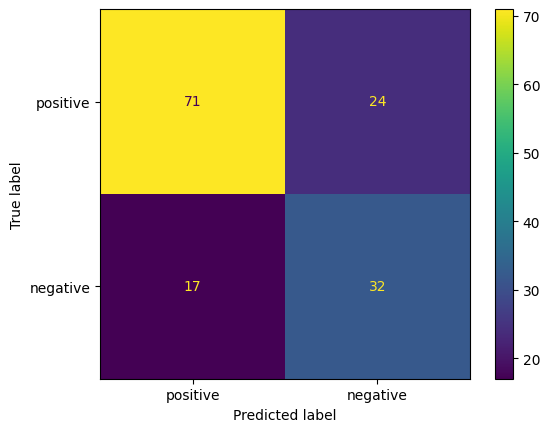

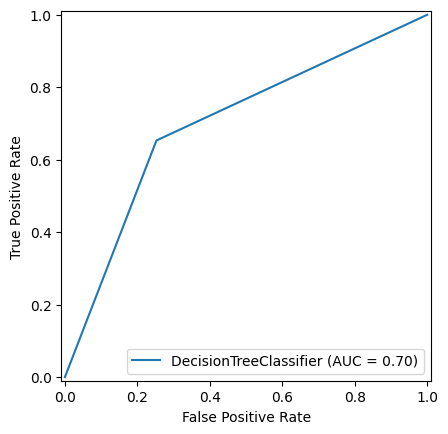

In [10]:
clsf = DecisionTreeClassifier(max_depth=best_depth, random_state=17)
clsf = clsf.fit(X_train, y_train)
y_predict = clsf.predict(X_test)
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
accuracy = accuracy_score(y_test, y_predict)

plotConfusionMatrix(y_test, y_predict, 'DecisionTreeClassifier')
plotROC(y_test, y_predict, 'DecisionTreeClassifier')

# SVC

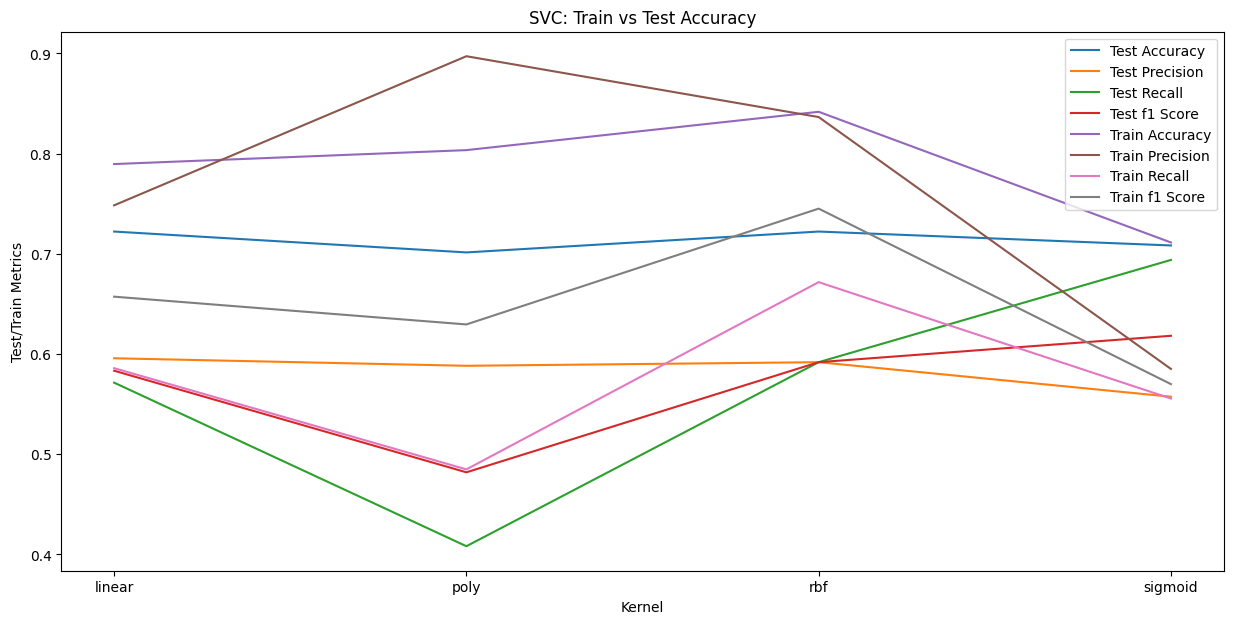

In [11]:
from sklearn.svm import SVC


kernels = ['linear', 'poly', 'rbf', 'sigmoid']

best_kernel = ''

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for kernel in kernels:
  svccls = SVC(kernel=kernel)
  svccls.fit(X_train, y_train)
  y_test_predict = svccls.predict(X_test)
  y_train_predict = svccls.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_kernel = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_kernel, kernel)

models.append('svc')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(kernels, model_test_scores, model_train_scores, 'Kernel', 'Test/Train Metrics', 'SVC: Train vs Test Accuracy')


In [12]:
print(f"SVC Classifier best_kernel = {best_kernel}")
print_best_metrics('SVC Classifier', best_test_metrics, best_train_metrics)


SVC Classifier best_kernel = sigmoid

SVC Classifier Classifier Test Metrics:
accuracy  =0.708
precision =0.557
recall    =0.694
f1        =0.618

SVC Classifier Classifier Train Metrics:
accuracy  =0.711
precision =0.585
recall    =0.556
f1        =0.57


Confusion Matrix for SVCClassifier


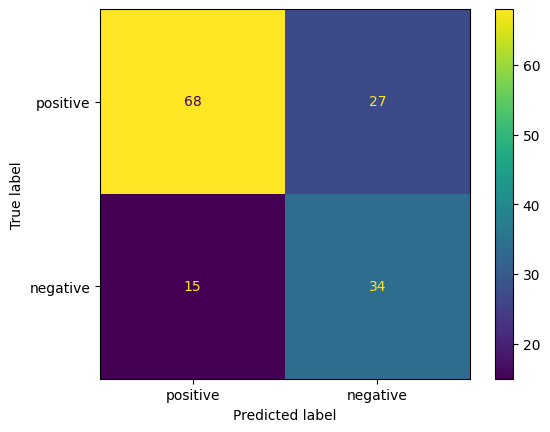

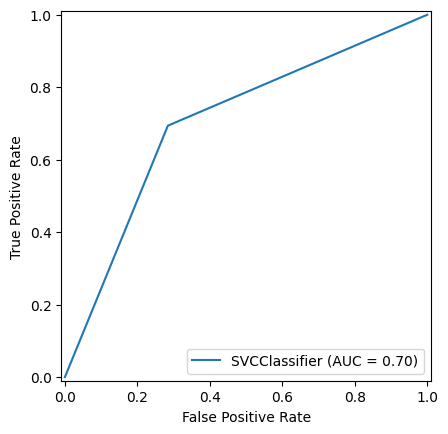

In [13]:

svccls = SVC(kernel=best_kernel)
svccls.fit(X_train, y_train)
y_predict = svccls.predict(X_test)
acuracy = accuracy_score(y_test,y_predict)

plotConfusionMatrix(y_test, y_predict, 'SVCClassifier')
plotROC(y_test, y_predict, 'SVCClassifier')

# Gradient Boosting Classifier

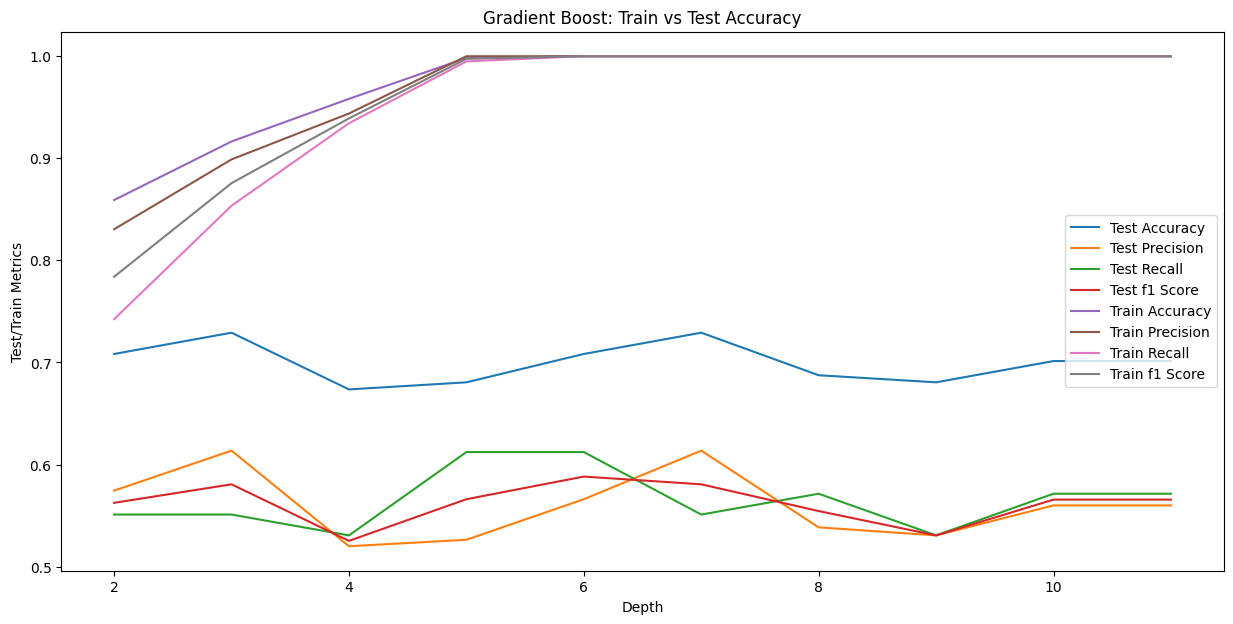

In [14]:
from sklearn.ensemble import GradientBoostingClassifier


best_depth = 0

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for depth in range(2,12):
  for estimators in [10]:
    clsf= GradientBoostingClassifier(n_estimators=estimators, learning_rate=1.0, max_depth=depth, random_state=0)
    clsf.fit(X_train, y_train)

    y_test_predict = clsf.predict(X_test)
    y_train_predict = clsf.predict(X_train)
    get_scores(y_test, y_test_predict, model_test_scores)
    get_scores(y_train, y_train_predict, model_train_scores)
    best_depth = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                                 best_test_metrics, best_train_metrics, best_depth, depth)



models.append('gradient_boost')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(range(2, 12), model_test_scores, model_train_scores, 'Depth', 'Test/Train Metrics', 'Gradient Boost: Train vs Test Accuracy')




In [15]:

print(f"Gradient Boost Classifier best_depth = {best_depth}")
print_best_metrics('DecisionTreeClassifier', best_test_metrics, best_train_metrics)


Gradient Boost Classifier best_depth = 5

DecisionTreeClassifier Classifier Test Metrics:
accuracy  =0.681
precision =0.526
recall    =0.612
f1        =0.566

DecisionTreeClassifier Classifier Train Metrics:
accuracy  =0.998
precision =1.0
recall    =0.995
f1        =0.997


Confusion Matrix for GradientBoostingClassifier


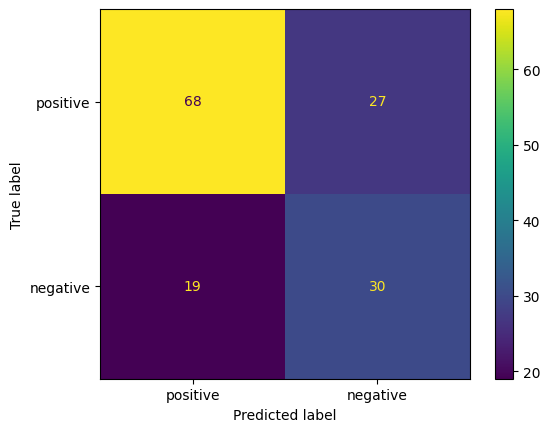

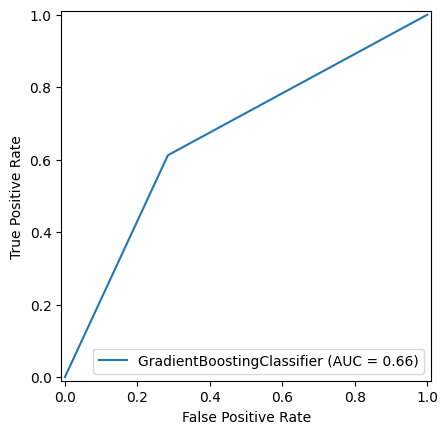

In [16]:
clsf= GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=best_depth, random_state=0)
clsf.fit(X_train, y_train)
y_predict = clsf.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'GradientBoostingClassifier')
plotROC(y_test, y_predict, 'GradientBoostingClassifier')

# Random Forest Classifier

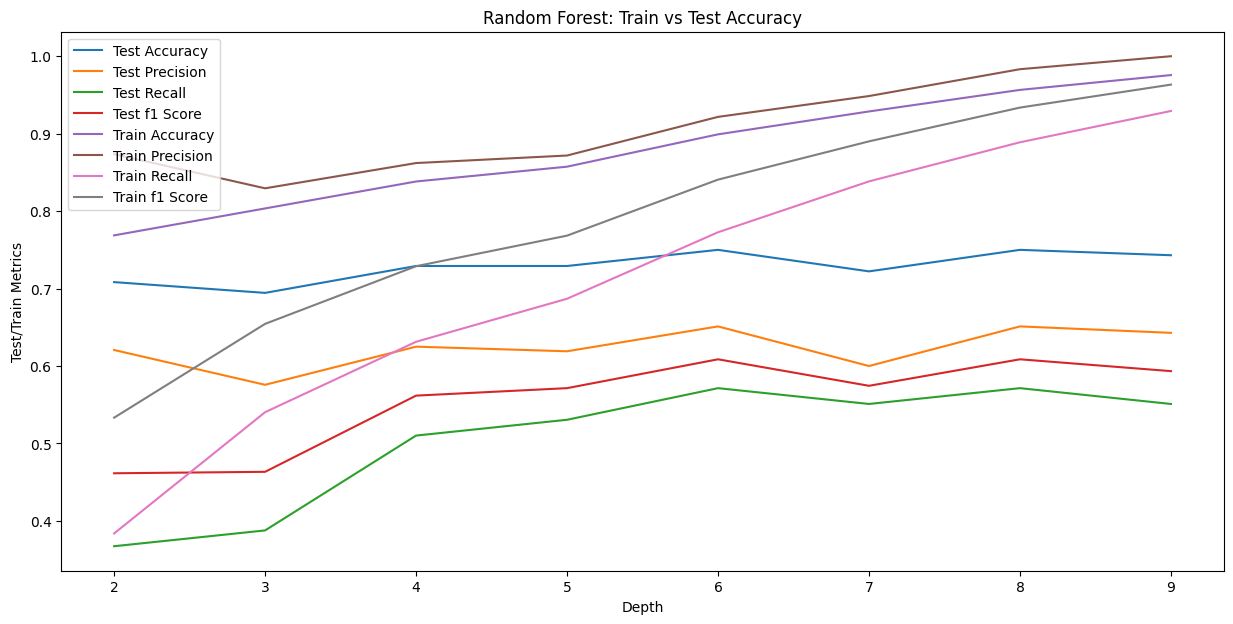

In [17]:
from sklearn.ensemble import RandomForestClassifier

best_depth = 0

model_test_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}
model_train_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for depth in range(2, 10):
  rndfc = RandomForestClassifier(max_depth=depth, criterion='entropy', random_state=0)
  rndfc.fit(X_train, y_train)

  y_test_predict = rndfc.predict(X_test)
  y_train_predict = rndfc.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_depth = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_depth, depth)


models.append('random_forest')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(range(2, 10), model_test_scores, model_train_scores, 'Depth', 'Test/Train Metrics', 'Random Forest: Train vs Test Accuracy')


In [18]:
print(f"Random Forest Classifier best_depth = {best_depth}")
print_best_metrics('RandomForestClassifier', best_test_metrics, best_train_metrics)

Random Forest Classifier best_depth = 6

RandomForestClassifier Classifier Test Metrics:
accuracy  =0.75
precision =0.651
recall    =0.571
f1        =0.609

RandomForestClassifier Classifier Train Metrics:
accuracy  =0.899
precision =0.922
recall    =0.773
f1        =0.841


Confusion Matrix for RandomForestClassifier


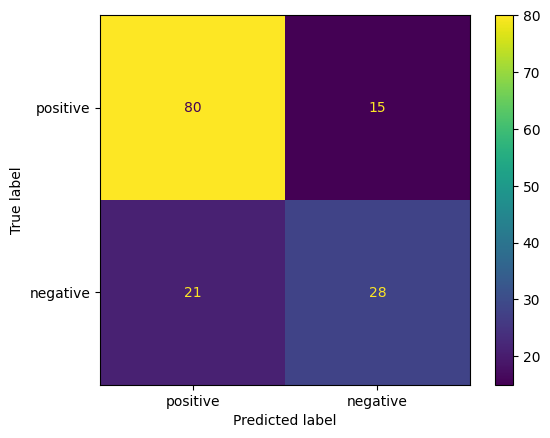

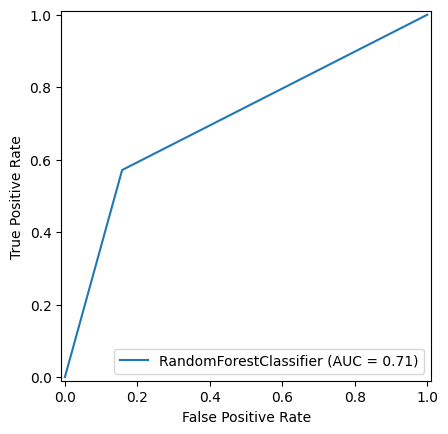

In [19]:
rndfc = RandomForestClassifier(max_depth=best_depth, criterion='entropy', random_state=0)
rndfc.fit(X_train, y_train)
y_predict = rndfc.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'RandomForestClassifier')
plotROC(y_test, y_predict, 'RandomForestClassifier')

# Logistic Regression

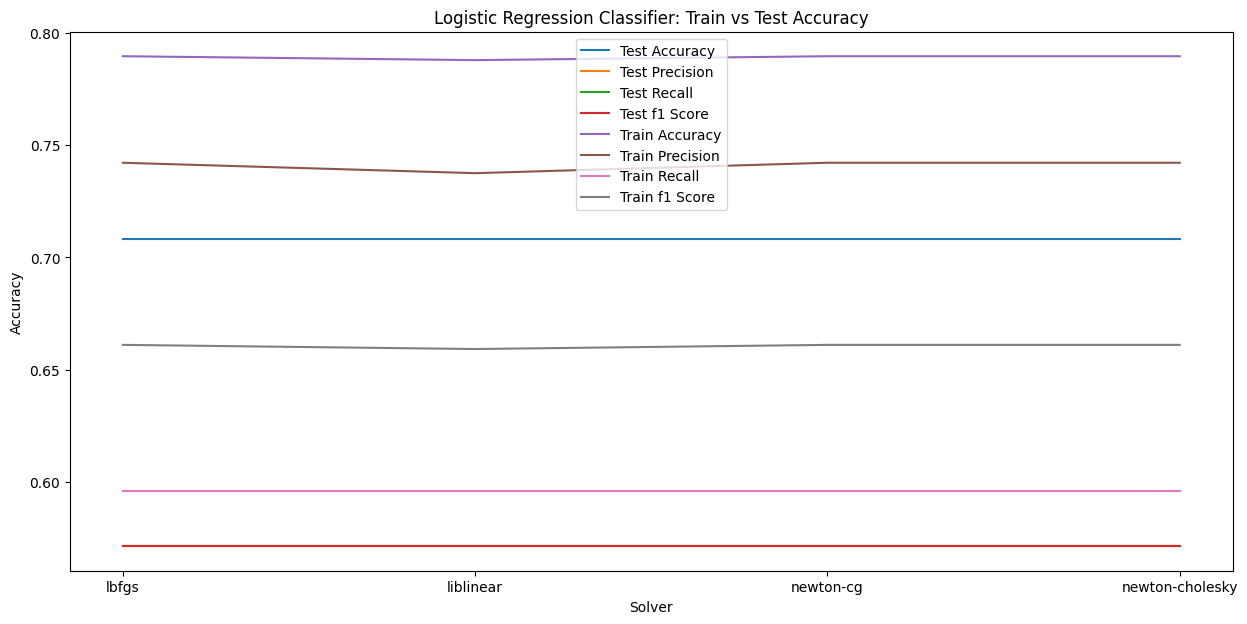

In [20]:
from sklearn import linear_model

best_solver = ''

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
for solver in solvers:
  lgst = linear_model.LogisticRegression(max_iter=500, solver=solver);
  lgst.fit(X_train, y_train)

  y_test_predict = lgst.predict(X_test)
  y_train_predict = lgst.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_solver = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_solver, solver)

models.append('logistic_regression')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(solvers, model_test_scores, model_train_scores, 'Solver', 'Accuracy', 'Logistic Regression Classifier: Train vs Test Accuracy')



In [21]:


print(f"Logistic Regression Classifier best_solver = {best_solver}")
print_best_metrics('LogisticRegressionClassifier', best_test_metrics, best_train_metrics)

Logistic Regression Classifier best_solver = lbfgs

LogisticRegressionClassifier Classifier Test Metrics:
accuracy  =0.708
precision =0.571
recall    =0.571
f1        =0.571

LogisticRegressionClassifier Classifier Train Metrics:
accuracy  =0.79
precision =0.742
recall    =0.596
f1        =0.661


Confusion Matrix for LogisticRegressionClassifier


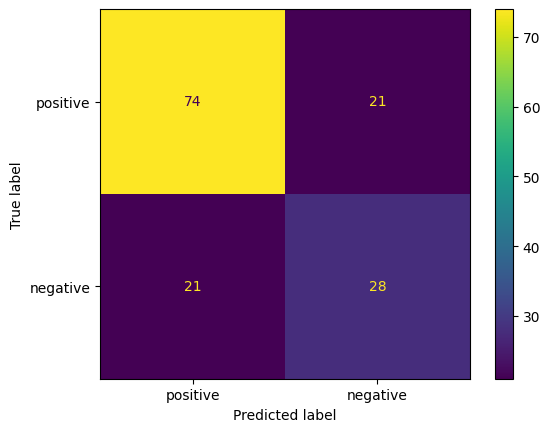

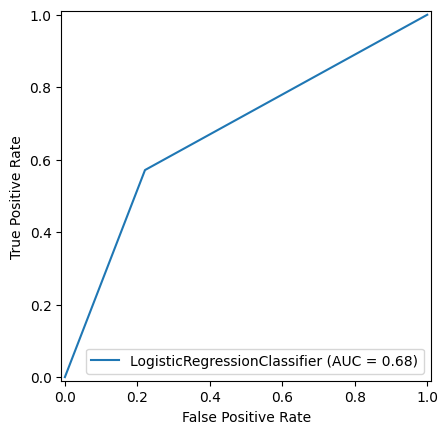

In [22]:
lgst = linear_model.LogisticRegression(max_iter=500, solver=best_solver);
lgst.fit(X_train, y_train)
y_predict = lgst.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'LogisticRegressionClassifier')
plotROC(y_test, y_predict, 'LogisticRegressionClassifier')

# KNN Classifier

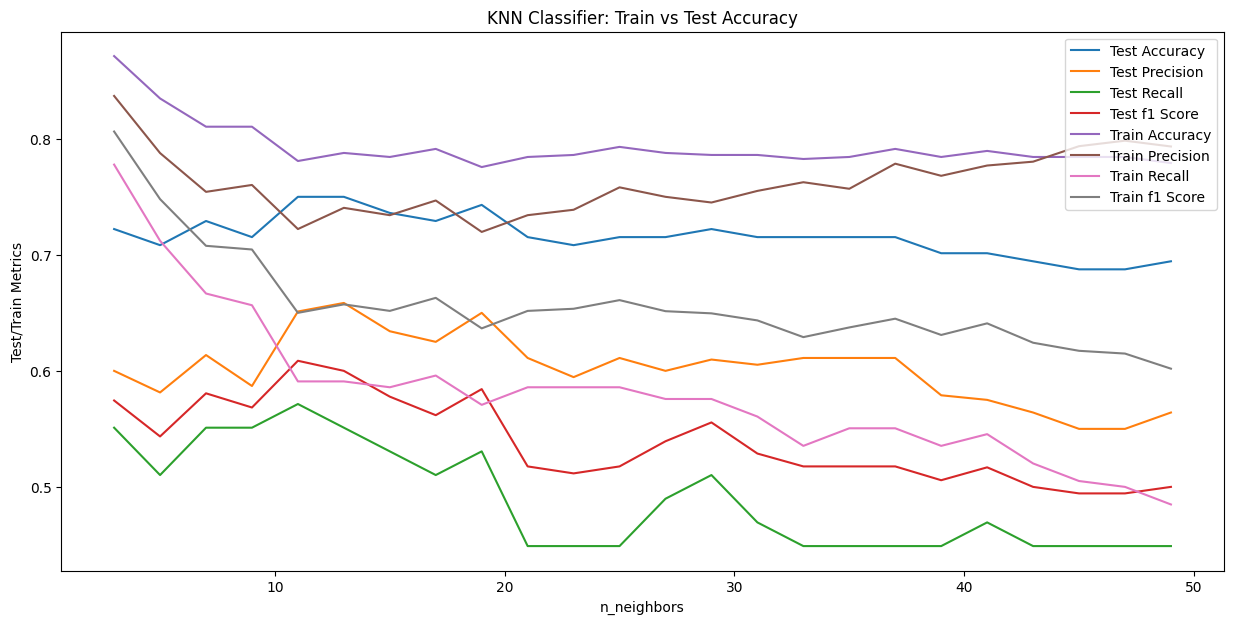

In [23]:
from sklearn.neighbors import KNeighborsClassifier

best_k = 0

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for k in range(3,50,2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_test_predict = knn.predict(X_test)
  y_train_predict = knn.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_k = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                           best_test_metrics, best_train_metrics, best_k, k)

models.append('knn')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(range(3,50,2), model_test_scores, model_train_scores, 'n_neighbors', 'Test/Train Metrics', 'KNN Classifier: Train vs Test Accuracy')


In [24]:

print(f"KNN Classifier best_k = {best_k}")
print_best_metrics('KNeighborsClassifier', best_test_metrics, best_train_metrics)

KNN Classifier best_k = 11

KNeighborsClassifier Classifier Test Metrics:
accuracy  =0.75
precision =0.651
recall    =0.571
f1        =0.609

KNeighborsClassifier Classifier Train Metrics:
accuracy  =0.781
precision =0.722
recall    =0.591
f1        =0.65


Confusion Matrix for KNNClassifier


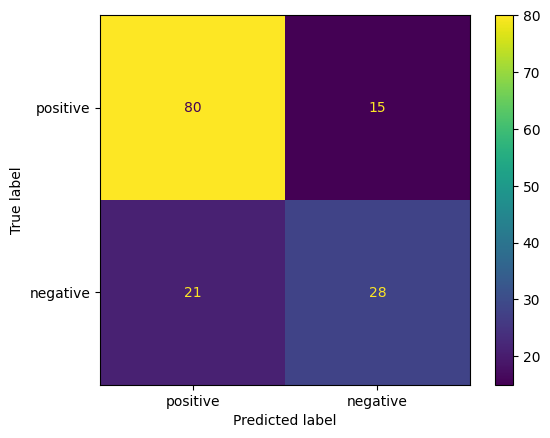

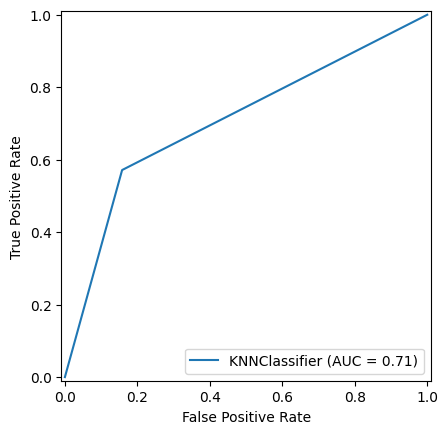

In [25]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'KNNClassifier')
plotROC(y_test, y_predict, 'KNNClassifier')

# MLP Classifier

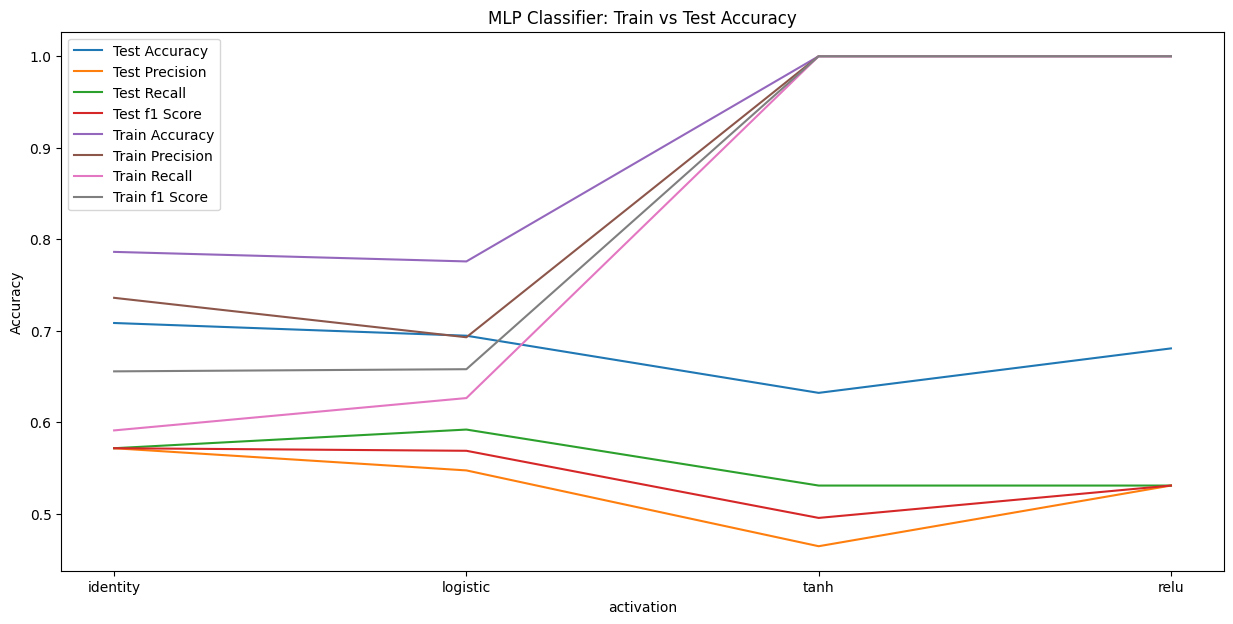

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings as w
w.filterwarnings('ignore')

reset_best_metrics(best_test_metrics, best_train_metrics)
reset_model_scores(model_test_scores, model_train_scores)


activations = ['identity', 'logistic', 'tanh', 'relu']
best_activation = ''

for solver in ['adam']:
  for activation in activations:
    for layers in [50]:
      for iters in [600]:
        clsf = MLPClassifier(solver=solver, activation=activation, alpha=1e-4, hidden_layer_sizes=(50,layers, 50), random_state=1, max_iter=iters)
        clsf.fit(X_train, y_train)
        y_test_predict = clsf.predict(X_test)
        y_train_predict = clsf.predict(X_train)
        get_scores(y_test, y_test_predict, model_test_scores)
        get_scores(y_train, y_train_predict, model_train_scores)
        best_activation = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                                          best_test_metrics, best_train_metrics, best_activation, activation)

models.append('mlp')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(activations, model_test_scores, model_train_scores, 'activation', 'Accuracy', 'MLP Classifier: Train vs Test Accuracy')




In [27]:

print(f"MLP Classifier best_activation = {best_activation}")
print_best_metrics('MLPClassifier', best_test_metrics, best_train_metrics)


MLP Classifier best_activation = logistic

MLPClassifier Classifier Test Metrics:
accuracy  =0.694
precision =0.547
recall    =0.592
f1        =0.569

MLPClassifier Classifier Train Metrics:
accuracy  =0.776
precision =0.693
recall    =0.626
f1        =0.658


Confusion Matrix for MLPClassifier


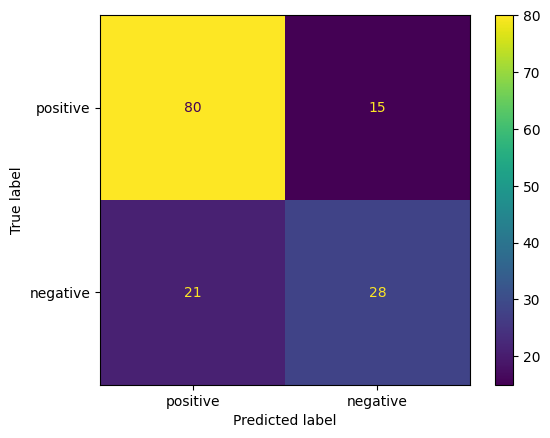

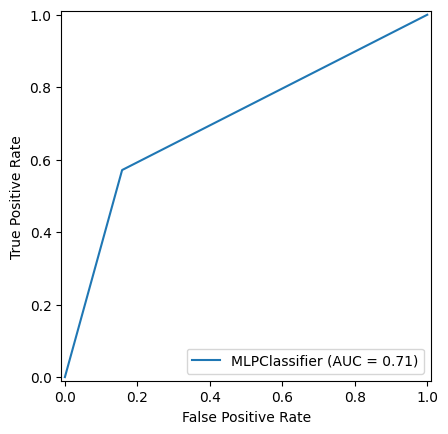

In [28]:
clsf = MLPClassifier(solver='adam', activation=best_activation, alpha=1e-4, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=600)
clsf.fit(X_train, y_train)
bc_predict_y_test = clsf.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'MLPClassifier')
plotROC(y_test, y_predict, 'MLPClassifier')

## Keras Sequential Neural Network

In [29]:

import tensorflow as tf
from tensorflow import keras
from threading import activeCount
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import warnings as w
w.filterwarnings('ignore')

reset_best_metrics(best_test_metrics, best_train_metrics)
reset_model_scores(model_test_scores, model_train_scores)

node_count = 150
dropout_rate = 0.15

activations = ['selu', 'elu', 'tanh', 'relu']
for activation in activations:
  print(f"Training model with activation={activation}")
  model = Sequential()
  sgd = optimizers.Adam(learning_rate=0.001)
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(node_count, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['recall', 'accuracy'])
  model.fit(X_train, y_train, epochs=150, batch_size=int((len(X_train))), verbose=0)
  y_test_predict = model.predict(X_test)
  y_test_predict = [ 0 if x[0] < 0.5 else 1 for x in y_test_predict]
  y_predict_train = model.predict(X_train)
  y_train_predict = [ 0 if x[0] < 0.5 else 1 for x in y_predict_train]
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_activation = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                                    best_test_metrics, best_train_metrics, best_activation, activation)

models.append('keras_sequential')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

Training model with activation=selu
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training model with activation=elu
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training model with activation=tanh
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training model with activation=relu
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


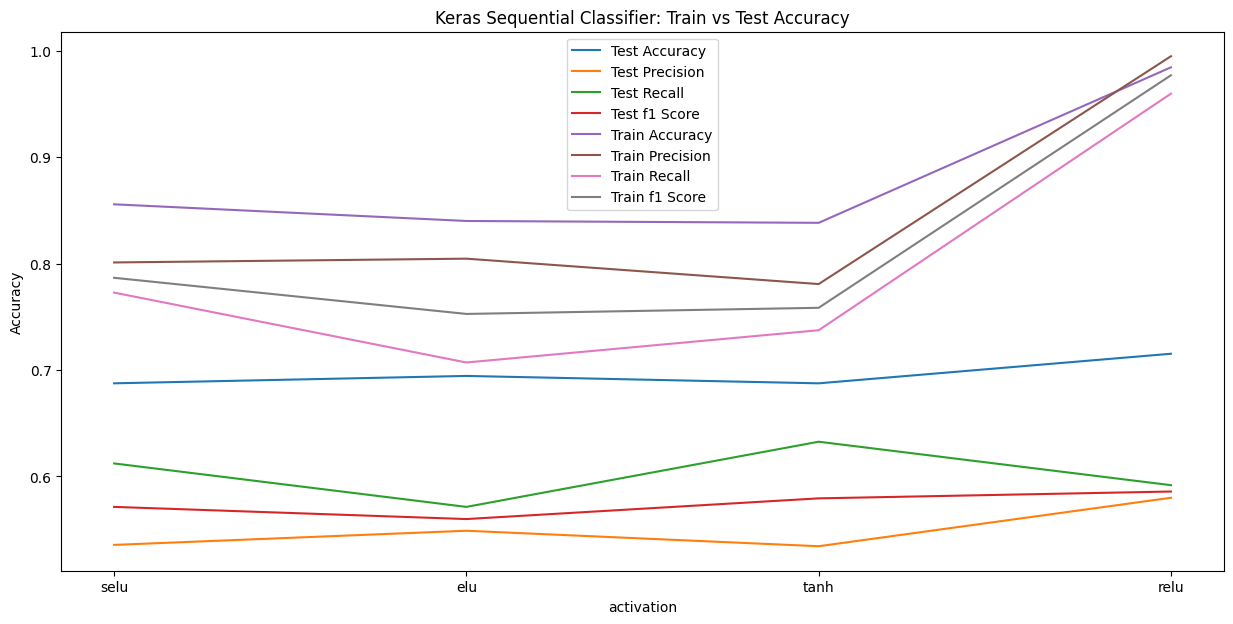

In [30]:
plot_scores(activations, model_test_scores, model_train_scores, 'activation', 'Accuracy', 'Keras Sequential Classifier: Train vs Test Accuracy')

In [31]:
print(f"Keras Sequential Classifier best_activation = {best_activation}")
print_best_metrics('Keras Sequential Classifier', best_test_metrics, best_train_metrics)

Keras Sequential Classifier best_activation = tanh

Keras Sequential Classifier Classifier Test Metrics:
accuracy  =0.688
precision =0.534
recall    =0.633
f1        =0.579

Keras Sequential Classifier Classifier Train Metrics:
accuracy  =0.838
precision =0.781
recall    =0.737
f1        =0.758


Confusion Matrix for Keras Sequential NN


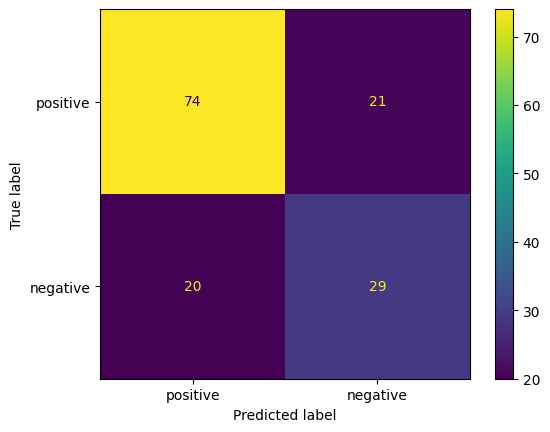

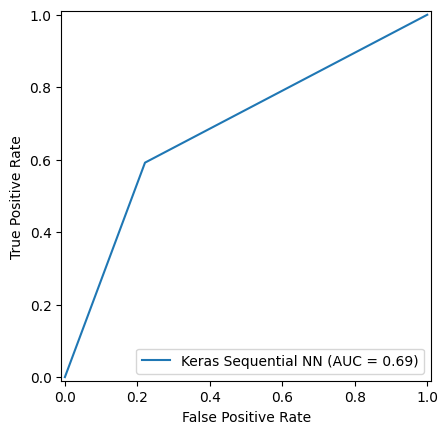

In [32]:
plotConfusionMatrix(y_test, y_test_predict, 'Keras Sequential NN')
plotROC(y_test, y_test_predict, 'Keras Sequential NN')

# Summary of Base-line results (No significant hyperparameter search)

In [33]:

df_results = pd.DataFrame({'model': models, 'test_recall': all_best_test_metrics['recall'], 'train_recall': all_best_train_metrics['recall'],  'test_precision': all_best_test_metrics['precision'], 'train_precision': all_best_train_metrics['precision'], 'test_f1': all_best_test_metrics['f1'], 'train_f1': all_best_train_metrics['f1'], 'test_accuracy': all_best_test_metrics['accuracy'], 'train_accuracy': all_best_train_metrics['accuracy']})
df_results.sort_values(by='test_recall', ascending=False, inplace=True)
df_results

,model,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
1,svc,0.693878,0.555556,0.557377,0.585106,0.618182,0.569948,0.708333,0.711304
0,decision_tree,0.653061,0.808081,0.571429,0.711111,0.609524,0.756501,0.715278,0.820870
7,keras_sequential,0.632653,0.737374,0.534483,0.780749,0.579439,0.758442,0.687500,0.838261
2,gradient_boost,0.612245,0.994949,0.526316,1.000000,0.566038,0.997468,0.680556,0.998261
6,mlp,0.591837,0.626263,0.547170,0.692737,0.568627,0.657825,0.694444,0.775652
3,random_forest,0.571429,0.772727,0.651163,0.921687,0.608696,0.840659,0.750000,0.899130
5,knn,0.571429,0.590909,0.651163,0.722222,0.608696,0.650000,0.750000,0.780870
4,logistic_regression,0.571429,0.595960,0.571429,0.742138,0.571429,0.661064,0.708333,0.789565


## Hyper Parameter Exploration

In [34]:
# Prepare Models and Hyper Parametres to be explored

import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models_set_1 = {
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'max_depth': range(2,11)}),
    'svc': (SVC(), {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree' :[3]})
}
models_set_2 = {
    'gradientboostclassifier' : (GradientBoostingClassifier(), {'max_depth': range(2,10), 'n_estimators' : range(10,120,50),\
                                                              'learning_rate' :[ 0.1, 1, 10]}),
    'randomforestclassifier': (RandomForestClassifier(), {'max_depth': range(2,11), 'criterion': ['gini', 'entropy', 'log_loss'], 'n_estimators' : range(10,120,50)})
}
models_set_3 = {
    'logisticregression': (LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1], 'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']}),
    'knn': (KNeighborsClassifier(), {'n_neighbors': range(3,22,2)})
}
models_set_4 ={
    'mlp' : (MLPClassifier(), {'solver':['lbfgs', 'sgd', 'adam'], 'activation':['identity', 'logistic', 'tanh', 'relu'], 'alpha':[1e-3, 1e-2, 1e-1],
                               'hidden_layer_sizes':[(50, 50, 50)], 'max_iter':[250, 500]})
}

def score_model(y_train, y_test, y_train_predict, y_test_predict):
    train_accuracy_score = accuracy_score(y_true=y_train, y_pred=y_train_predict)
    train_precision_score = precision_score(y_true=y_train, y_pred=y_train_predict)
    train_recall_score = recall_score(y_true=y_train, y_pred=y_train_predict)
    train_f1_score = f1_score(y_true=y_train, y_pred=y_train_predict)

    test_accuracy_score = accuracy_score(y_true=y_test, y_pred=y_test_predict)
    test_precision_score = precision_score(y_true=y_test, y_pred=y_test_predict)
    test_recall_score = recall_score(y_true=y_test, y_pred=y_test_predict)
    test_f1_score = f1_score(y_true=y_test, y_pred=y_test_predict)

    return (train_accuracy_score, test_accuracy_score, train_precision_score, test_precision_score,\
            train_recall_score, test_recall_score, train_f1_score, test_f1_score)

def gridSearchModels(models, scoring, X_train, X_test, y_train, y_test, results, cfms, rocs, best_models):
    for model_name, (model, params) in models.items():
        if model_name == 'gradientboostclassifier' and scoring == 'precision':
            # Gradient boost does not grid-search well with precision
            continue
        # Perform grid search
        grid_search = GridSearchCV(model, param_grid=params, scoring=scoring, cv=5, n_jobs=-1)

        # Train the model and time it
        print(f'\r                                                                   ', end='')
        print(f'\rModel {model_name}, Scoring={scoring}: train phase', end='')
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        train_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
        print(f'\r                                                                   ', end='')
        print(f'\rModel {model_name}, Scoring={scoring}: predict phase', end='')

        # Get the best estimator
        best_model = grid_search.best_estimator_
        best_models[scoring][model_name] = best_model
        y_train_predict = best_model.predict(X_train)
        y_test_predict = best_model.predict(X_test)

        print(f'\r                                                                   ', end='')
        print(f'\rModel {model_name}, Scoring={scoring}: completed', end='')
        model_name_and_scoring = model_name + "-" + scoring

        cfms.append([model_name_and_scoring, confusion_matrix(y_test_predict, y_test)])

        fpr, tpr, thresholds = roc_curve(y_test, y_test_predict)
        roc_auc = auc(fpr, tpr)
        rocs.append([model_name_and_scoring, fpr, tpr, roc_auc])

        # Append the results
        results.append([model_name_and_scoring, train_time, str(grid_search.best_params_)] +\
                       list(score_model(y_train, y_test, y_train_predict, y_test_predict)))
    return (results, cfms, rocs, best_models)


In [35]:
results = []
cfms = []
rocs = []

best_models = {'accuracy':{}, 'precision':{}, 'recall':{}, 'f1':{}}

for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    (results, cfms, rocs, best_models) = gridSearchModels(models_set_1, scoring, X_train, X_test, y_train, y_test, results, cfms, rocs, best_models)

Model svc, Scoring=f1: completed

In [36]:
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    (results, cfms, rocs, best_models) = gridSearchModels(models_set_2, scoring, X_train, X_test, y_train, y_test, results, cfms, rocs, best_models)

Model randomforestclassifier, Scoring=f1: completed

In [37]:
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    (results, cfms, rocs, best_models) = gridSearchModels(models_set_3, scoring, X_train, X_test, y_train, y_test, results, cfms, rocs, best_models)

Model knn, Scoring=f1: completed

In [38]:
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    (results, cfms, rocs, best_models) = gridSearchModels(models_set_4, scoring, X_train, X_test, y_train, y_test, results, cfms, rocs, best_models)

Model mlp, Scoring=f1: completed

In [39]:
#
# Models sorted by test accuracy
#
results.sort(key = lambda row: row[4], reverse=True)

results_df = pd.DataFrame(results, columns=['Model Name-scoring', 'train time', 'best params', 'train accuracy score',\
                                            'test accuracy score', 'train precision score', 'test precision score',\
                                            'train recall score', 'test recall score', 'train f1 score', 'test f1 score'])
results_df.set_index('Model Name-scoring', inplace=True)

results_df

,train time,best params,train accuracy score,test accuracy score,train precision score,test precision score,train recall score,test recall score,train f1 score,test f1 score
Model Name-scoring,,,,,,,,,,
gradientboostclassifier-f1,1.029623,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.989565,0.743056,0.994845,0.620000,0.974747,0.632653,0.984694,0.626263
knn-accuracy,0.059519,{'n_neighbors': 19},0.775652,0.743056,0.719745,0.650000,0.570707,0.530612,0.636620,0.584270
knn-precision,0.059187,{'n_neighbors': 19},0.775652,0.743056,0.719745,0.650000,0.570707,0.530612,0.636620,0.584270
knn-f1,0.071082,{'n_neighbors': 19},0.775652,0.743056,0.719745,0.650000,0.570707,0.530612,0.636620,0.584270
svc-precision,0.064824,"{'C': 0.1, 'degree': 3, 'kernel': 'rbf'}",0.787826,0.736111,0.816667,0.666667,0.494949,0.448980,0.616352,0.536585
randomforestclassifier-recall,0.541984,"{'criterion': 'entropy', 'max_depth': 9, 'n_es...",0.968696,0.736111,0.983871,0.627907,0.924242,0.551020,0.953125,0.586957
svc-f1,0.063427,"{'C': 1, 'degree': 3, 'kernel': 'linear'}",0.789565,0.722222,0.748387,0.595745,0.585859,0.571429,0.657224,0.583333
gradientboostclassifier-accuracy,1.005832,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.852174,0.722222,0.850932,0.600000,0.691919,0.551020,0.763231,0.574468
randomforestclassifier-f1,0.591008,"{'criterion': 'gini', 'max_depth': 8, 'n_estim...",0.965217,0.722222,0.994444,0.604651,0.904040,0.530612,0.947090,0.565217


In [40]:

#
# Models sorted by test recall
#
results.sort(key = lambda row: row[8], reverse=True)

results_df = pd.DataFrame(results, columns=['Model Name-scoring', 'train time', 'best params', 'train accuracy score',\
                                            'test accuracy score', 'train precision score', 'test precision score',\
                                            'train recall score', 'test recall score', 'train f1 score', 'test f1 score'])
results_df.set_index('Model Name-scoring', inplace=True)

results_df

,train time,best params,train accuracy score,test accuracy score,train precision score,test precision score,train recall score,test recall score,train f1 score,test f1 score
Model Name-scoring,,,,,,,,,,
svc-recall,0.063060,"{'C': 1, 'degree': 3, 'kernel': 'sigmoid'}",0.711304,0.708333,0.585106,0.557377,0.555556,0.693878,0.569948,0.618182
decisiontreeclassifier-recall,0.028204,{'max_depth': 4},0.820870,0.715278,0.711111,0.571429,0.808081,0.653061,0.756501,0.609524
decisiontreeclassifier-f1,0.026719,{'max_depth': 4},0.820870,0.715278,0.711111,0.571429,0.808081,0.653061,0.756501,0.609524
gradientboostclassifier-f1,1.029623,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.989565,0.743056,0.994845,0.620000,0.974747,0.632653,0.984694,0.626263
mlp-accuracy,3.724284,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.793043,0.722222,0.742331,0.584906,0.611111,0.632653,0.670360,0.607843
mlp-f1,3.712329,"{'activation': 'tanh', 'alpha': 0.001, 'hidden...",0.796522,0.722222,0.748466,0.588235,0.616162,0.612245,0.675900,0.600000
logisticregression-recall,0.026121,"{'C': 0.001, 'solver': 'liblinear'}",0.763478,0.708333,0.656566,0.566038,0.656566,0.612245,0.656566,0.588235
mlp-precision,3.734730,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.805217,0.715278,0.762195,0.580000,0.631313,0.591837,0.690608,0.585859
svc-f1,0.063427,"{'C': 1, 'degree': 3, 'kernel': 'linear'}",0.789565,0.722222,0.748387,0.595745,0.585859,0.571429,0.657224,0.583333


## Voting Classifier based on Best Models

In [42]:
from sklearn.ensemble import VotingClassifier

voting_results = []

for scoring in ['accuracy', 'precision', 'recall', 'f1']:
  if scoring != 'precision':
    optimized_voting_classifier = VotingClassifier(estimators=[
        ('decisiontreeclassifier', best_models[scoring]['decisiontreeclassifier']),
        ('svc', best_models[scoring]['svc']),
        ('gradientboostclassifier', best_models[scoring]['gradientboostclassifier']),
        ('randomforestclassifier', best_models[scoring]['randomforestclassifier']),
        ('logisticregression', best_models[scoring]['logisticregression']),
        ('knn', best_models[scoring]['knn']),
        ('mlp', best_models[scoring]['mlp']),
    ])
  else:
    optimized_voting_classifier = VotingClassifier(estimators=[
      ('decisiontreeclassifier', best_models[scoring]['decisiontreeclassifier']),
      ('svc', best_models[scoring]['svc']),
      ('randomforestclassifier', best_models[scoring]['randomforestclassifier']),
      ('logisticregression', best_models[scoring]['logisticregression']),
      ('knn', best_models[scoring]['knn']),
      ('mlp', best_models[scoring]['mlp']),
    ])

  optimized_voting_classifier.fit(X_train, y_train)
  y_test_predict = optimized_voting_classifier.predict(X_test)
  y_train_predict = optimized_voting_classifier.predict(X_train)

  voting_results.append([scoring] + list(score_model(y_train, y_test, y_train_predict, y_test_predict)))

# Sort by recall

voting_results.sort(key = lambda row: row[6], reverse=True)
metrics_df = pd.DataFrame(voting_results, columns=['scoring', 'train_accuracy_score', 'test_accuracy_score', 'train_precision_score', 'test_precision_score',\
            'train_recall_score', 'test_recall_score', 'train_f1_score', 'test_f1_score'])
metrics_df.set_index('scoring', inplace=True)
metrics_df

,train_accuracy_score,test_accuracy_score,train_precision_score,test_precision_score,train_recall_score,test_recall_score,train_f1_score,test_f1_score
scoring,,,,,,,,
recall,0.888696,0.715278,0.848958,0.574074,0.823232,0.632653,0.835897,0.601942
f1,0.829565,0.722222,0.804878,0.595745,0.666667,0.571429,0.729282,0.583333
accuracy,0.800000,0.736111,0.782313,0.627907,0.580808,0.551020,0.666667,0.586957
precision,0.786087,0.722222,0.815126,0.628571,0.489899,0.448980,0.611987,0.523810


# Feature Importance Study: Best 'recall' models

## Feature importance: Decision Tree

In [47]:
# Helper functions to extract feature importance

def sort_and_normalize_feature_importance(feature_importance_df):
  feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
  scl = StandardScaler()
  feature_importance_df['importance'] = scl.fit_transform(feature_importance_df[['importance']])
  feature_importance_df.set_index('feature', inplace=True)
  return feature_importance_df

def get_tree_feature_importance(model, X_train, y_train):
  model.fit(X_train, y_train)
  return model.feature_importances_

importances_tree = get_tree_feature_importance(best_models['recall']['decisiontreeclassifier'], X_train, y_train) # .feature_importances_
feature_importance_decisiontree_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': importances_tree}))

print("\nFeature Importance: Decision Tree")
feature_importance_decisiontree_df


Feature Importance: Decision Tree


,importance
feature,
Glucose,2.487109
Age,0.273229
BMI,0.153529
DiabetesPedigreeFunction,-0.529593
Insulin,-0.534385
BloodPressure,-0.537759
SkinThickness,-0.656065
Pregnancies,-0.656065


## Feature Importance: SVC

In [48]:
from sklearn.inspection import permutation_importance
result_svc = permutation_importance(best_models['recall']['svc'], X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)

feature_importance_svc_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': result_svc.importances_mean}))

print("\nFeature Importance: SVC")
feature_importance_svc_df


Feature Importance: SVC


,importance
feature,
Glucose,2.176115
BMI,0.877094
DiabetesPedigreeFunction,0.038357
Insulin,-0.002557
Pregnancies,-0.534439
SkinThickness,-0.728781
Age,-0.841295
BloodPressure,-0.984494


## Feature Importance: Gradient Boost Classifier

In [52]:
importances_tree = get_tree_feature_importance(best_models['recall']['gradientboostclassifier'], X_train, y_train)
feature_importance_gradientboostclassifier_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': importances_tree}))

print("\nFeature Importance: Gradient Boost Classifier")
feature_importance_gradientboostclassifier_df


Feature Importance: Gradient Boost Classifier


,importance
feature,
BMI,0.809035
DiabetesPedigreeFunction,0.759665
Glucose,0.587438
Age,0.526516
Insulin,0.392661
BloodPressure,-0.175446
Pregnancies,-0.512790
SkinThickness,-2.387080


## Feature Importance: Random Forest Classifier

In [54]:
importances_tree = get_tree_feature_importance(best_models['recall']['randomforestclassifier'], X_train, y_train)
feature_importance_randomforestclassifier_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': importances_tree}))

print("\nFeature Importance: Random Forest Classifier")
feature_importance_randomforestclassifier_df


Feature Importance: Random Forest Classifier


,importance
feature,
Glucose,2.364192
BMI,0.482075
Age,0.247564
DiabetesPedigreeFunction,-0.223925
BloodPressure,-0.650015
Pregnancies,-0.709907
SkinThickness,-0.743721
Insulin,-0.766264


## Feature Importance: Logistic Regression

In [55]:
best_models['recall']['logisticregression'].fit(X_train, y_train)
coefficients_linear = best_models['recall']['logisticregression'].coef_[0]

feature_importance_logisticregression_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': coefficients_linear}))

print("\nFeature importance: Logistic Regression")
feature_importance_logisticregression_df


Feature importance: Logistic Regression


,importance
feature,
Glucose,2.289167
Age,0.421209
BMI,0.279152
Pregnancies,-0.161708
DiabetesPedigreeFunction,-0.410478
BloodPressure,-0.471772
Insulin,-0.660905
SkinThickness,-1.284665


## Feature Importance: KNN

In [56]:
result_knn = permutation_importance(best_models['recall']['knn'], X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)

feature_importance_knn_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': result_knn.importances_mean}))

print("\nFeature Importance: KNN")
feature_importance_knn_df


Feature Importance: KNN


,importance
feature,
Glucose,2.290080
BMI,0.268208
Age,0.171928
DiabetesPedigreeFunction,0.116911
Pregnancies,-0.405750
SkinThickness,-0.419504
Insulin,-0.653326
BloodPressure,-1.368546


## Feature Importance: MLP

In [57]:
result_mlp = permutation_importance(best_models['recall']['mlp'], X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)


feature_importance_mlp_df = sort_and_normalize_feature_importance(pd.DataFrame({'feature': X.columns, 'importance': result_mlp.importances_mean}))

print("\nFeature Importance: MLP")
feature_importance_mlp_df


Feature Importance: MLP


,importance
feature,
Glucose,1.733685
DiabetesPedigreeFunction,0.974869
Age,0.778138
BMI,-0.008783
BloodPressure,-0.472504
Pregnancies,-0.739495
Insulin,-0.908121
SkinThickness,-1.357790


## Feature Importance: Combined Plot

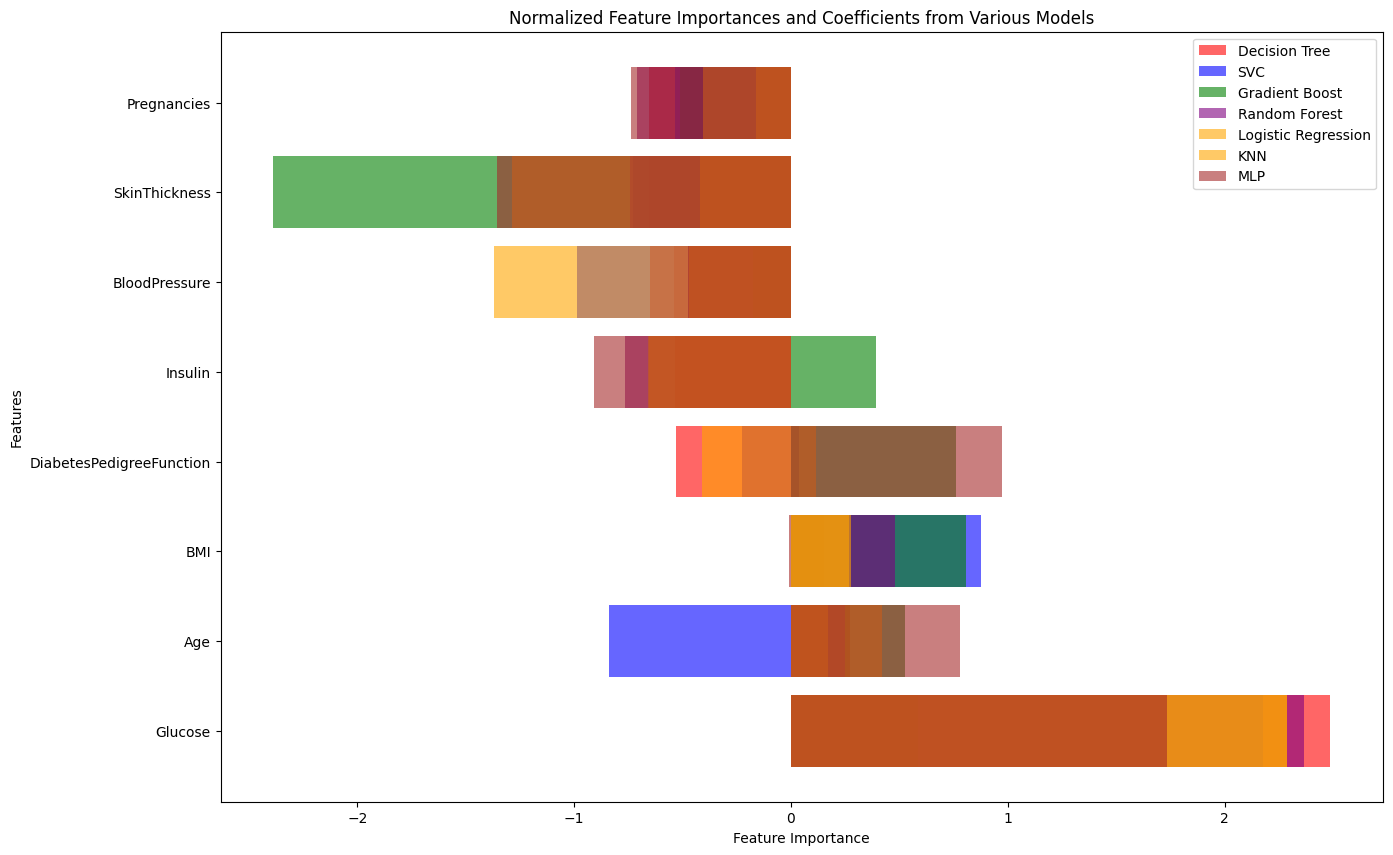

In [59]:

# Plotting the feature importances and coefficients
plt.figure(figsize=(15, 10))

feature_importances = [feature_importance_decisiontree_df, feature_importance_svc_df, feature_importance_gradientboostclassifier_df,\
                       feature_importance_randomforestclassifier_df, feature_importance_logisticregression_df, feature_importance_knn_df,\
                       feature_importance_mlp_df]
for fi in feature_importances:
  fi.reset_index(inplace=True)

# Plot Decision Tree feature importance
plt.barh(feature_importance_decisiontree_df['feature'], feature_importance_decisiontree_df['importance'], color='red', alpha=0.6, label='Decision Tree')
# Plot SVC feature importance
plt.barh(feature_importance_svc_df['feature'], feature_importance_svc_df['importance'], color='blue', alpha=0.6, label='SVC')
# Plot GradientBoost feature importance
plt.barh(feature_importance_gradientboostclassifier_df['feature'], feature_importance_gradientboostclassifier_df['importance'], color='green', alpha=0.6, label='Gradient Boost')
# Plot Random Forest feature importance
plt.barh(feature_importance_randomforestclassifier_df['feature'], feature_importance_randomforestclassifier_df['importance'], color='purple', alpha=0.6, label='Random Forest')
# Plot Logistic Regression coefficients
plt.barh(feature_importance_logisticregression_df['feature'], feature_importance_logisticregression_df['importance'], color='orange', alpha=0.6, label='Logistic Regression')
# Plot KNN feature importance
plt.barh(feature_importance_knn_df['feature'], feature_importance_knn_df['importance'], color='orange', alpha=0.6, label='KNN')
# Plot MLP feature importance
plt.barh(feature_importance_mlp_df['feature'], feature_importance_mlp_df['importance'], color='brown', alpha=0.6, label='MLP')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Normalized Feature Importances and Coefficients from Various Models')
plt.legend()
plt.show()

## Feature Importance: Wisdom of the Crowd Importance

In [61]:
all_feature_weights = []
for feature in X.columns:
    feature_importance = 0
    for df in feature_importances:
        feature_importance += df[df['feature'] == feature]['importance'].sum()
    all_feature_weights.append(feature_importance)

dic = { 'Features' : X.columns, 'Wisdom Of The Crowd Importance' : all_feature_weights}
df_weights = pd.DataFrame(dic)
df_weights.sort_values(by='Wisdom Of The Crowd Importance', ascending=False, inplace=True)
df_weights

,Features,Wisdom Of The Crowd Importance
1,Glucose,13.927787
5,BMI,2.860310
7,Age,1.577289
6,DiabetesPedigreeFunction,0.725806
4,Insulin,-3.132897
0,Pregnancies,-3.720154
2,BloodPressure,-4.660536
3,SkinThickness,-7.577606


## Polynomial Features Investigation

In [62]:
# Note that we only apply polynomial features to non-neural network models
# because neural networks are expected to build their non-linear features
# themselves
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

poly = PolynomialFeatures(degree=3)

X_normalized_poly = poly.fit_transform(X_scaled)

original_feature_count = X_scaled.shape[1]
_, poly_feature_count = X_normalized_poly.shape

print(f'Initial number of features={original_feature_count}, poly number of features={poly_feature_count}')

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_normalized_poly, y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train_small, y_train_small)

# Select at most 3 times the original features
sfm = SelectFromModel(lasso_cv, prefit=True, max_features=original_feature_count*3)
X_train_selected = sfm.transform(X_train_small)
X_test_selected = sfm.transform(X_test_small)

_, selected_feature_count = X_train_selected.shape
print(f'Selected number of features={selected_feature_count}')



Initial number of features=8, poly number of features=165
Selected number of features=24


# Polynomial features exploration: Decision Tree and SVC

In [63]:
results = []
cfms = []
rocs = []
best_poly_models = {'accuracy':{}, 'precision':{}, 'recall':{}, 'f1':{}}
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
  (results, cfms, rocs, best_poly_models) = gridSearchModels(models_set_1, scoring, X_train_selected, X_test_selected, y_train_small, y_test_small, results, cfms, rocs, best_poly_models)


Model svc, Scoring=f1: completed

In [64]:
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
   (results, cfms, rocs, best_poly_models) = gridSearchModels(models_set_2, scoring, X_train_selected, X_test_selected, y_train_small, y_test_small, results, cfms, rocs, best_poly_models)


Model randomforestclassifier, Scoring=f1: completed

In [65]:
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
   (results, cfms, rocs, best_poly_models) = gridSearchModels(models_set_3, scoring, X_train_selected, X_test_selected, y_train_small, y_test_small, results, cfms, rocs, best_poly_models)


Model knn, Scoring=f1: completed

In [66]:
# Sort by accuracy, decreasing
results.sort(key = lambda row: row[4], reverse=True)

results_df = pd.DataFrame(results, columns=['Model Name-scoring', 'train time', 'best params', 'train accuracy score', 'test accuracy score',
                                            'train precision score', 'test precision score', 'train recall score', 'test recall score',
                                            'train f1 score', 'test f1 score'])
results_df.set_index('Model Name-scoring', inplace=True)

results_df

,train time,best params,train accuracy score,test accuracy score,train precision score,test precision score,train recall score,test recall score,train f1 score,test f1 score
Model Name-scoring,,,,,,,,,,
svc-recall,0.258216,"{'C': 1, 'degree': 3, 'kernel': 'linear'}",0.815652,0.763889,0.806667,0.659574,0.611111,0.632653,0.695402,0.645833
svc-f1,0.315140,"{'C': 10, 'degree': 3, 'kernel': 'linear'}",0.812174,0.763889,0.792208,0.659574,0.616162,0.632653,0.693182,0.645833
randomforestclassifier-f1,0.671044,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.855652,0.763889,0.836257,0.674419,0.722222,0.591837,0.775068,0.630435
logisticregression-accuracy,0.210559,"{'C': 0.01, 'solver': 'liblinear'}",0.805217,0.763889,0.794521,0.666667,0.585859,0.612245,0.674419,0.638298
logisticregression-recall,0.035383,"{'C': 0.001, 'solver': 'liblinear'}",0.784348,0.763889,0.720238,0.653061,0.611111,0.653061,0.661202,0.653061
logisticregression-f1,0.034198,"{'C': 0.001, 'solver': 'liblinear'}",0.784348,0.763889,0.720238,0.653061,0.611111,0.653061,0.661202,0.653061
svc-accuracy,0.244859,"{'C': 0.1, 'degree': 3, 'kernel': 'linear'}",0.817391,0.750000,0.816327,0.638298,0.606061,0.612245,0.695652,0.625000
randomforestclassifier-precision,0.656735,"{'criterion': 'log_loss', 'max_depth': 2, 'n_e...",0.789565,0.750000,0.781022,0.658537,0.540404,0.551020,0.638806,0.600000
knn-accuracy,0.029290,{'n_neighbors': 7},0.780870,0.743056,0.711765,0.642857,0.611111,0.551020,0.657609,0.593407


In [67]:
# Sort by recall, decreasing
results.sort(key = lambda row: row[8], reverse=True)

results_df = pd.DataFrame(results, columns=['Model Name-scoring', 'train time', 'best params', 'train accuracy score', 'test accuracy score',
                                            'train precision score', 'test precision score', 'train recall score', 'test recall score',
                                            'train f1 score', 'test f1 score'])
results_df.set_index('Model Name-scoring', inplace=True)

results_df

,train time,best params,train accuracy score,test accuracy score,train precision score,test precision score,train recall score,test recall score,train f1 score,test f1 score
Model Name-scoring,,,,,,,,,,
logisticregression-recall,0.035383,"{'C': 0.001, 'solver': 'liblinear'}",0.784348,0.763889,0.720238,0.653061,0.611111,0.653061,0.661202,0.653061
logisticregression-f1,0.034198,"{'C': 0.001, 'solver': 'liblinear'}",0.784348,0.763889,0.720238,0.653061,0.611111,0.653061,0.661202,0.653061
svc-recall,0.258216,"{'C': 1, 'degree': 3, 'kernel': 'linear'}",0.815652,0.763889,0.806667,0.659574,0.611111,0.632653,0.695402,0.645833
svc-f1,0.315140,"{'C': 10, 'degree': 3, 'kernel': 'linear'}",0.812174,0.763889,0.792208,0.659574,0.616162,0.632653,0.693182,0.645833
logisticregression-accuracy,0.210559,"{'C': 0.01, 'solver': 'liblinear'}",0.805217,0.763889,0.794521,0.666667,0.585859,0.612245,0.674419,0.638298
svc-accuracy,0.244859,"{'C': 0.1, 'degree': 3, 'kernel': 'linear'}",0.817391,0.750000,0.816327,0.638298,0.606061,0.612245,0.695652,0.625000
gradientboostclassifier-accuracy,1.951454,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.855652,0.736111,0.852761,0.612245,0.702020,0.612245,0.770083,0.612245
decisiontreeclassifier-accuracy,0.303875,{'max_depth': 4},0.817391,0.708333,0.743455,0.566038,0.717172,0.612245,0.730077,0.588235
decisiontreeclassifier-recall,0.042654,{'max_depth': 4},0.817391,0.708333,0.743455,0.566038,0.717172,0.612245,0.730077,0.588235
